In [41]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
from imblearn.under_sampling import TomekLinks
from sklearn.metrics import accuracy_score, recall_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from imblearn.over_sampling import SMOTE
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from collections import Counter

In [42]:
df = pd.read_csv("bank-additional-full.csv",sep=';')
df = df[["age","job","marital","education","housing","loan","campaign","previous","y"]]

# Explore Data Distribution

# Education Distribution

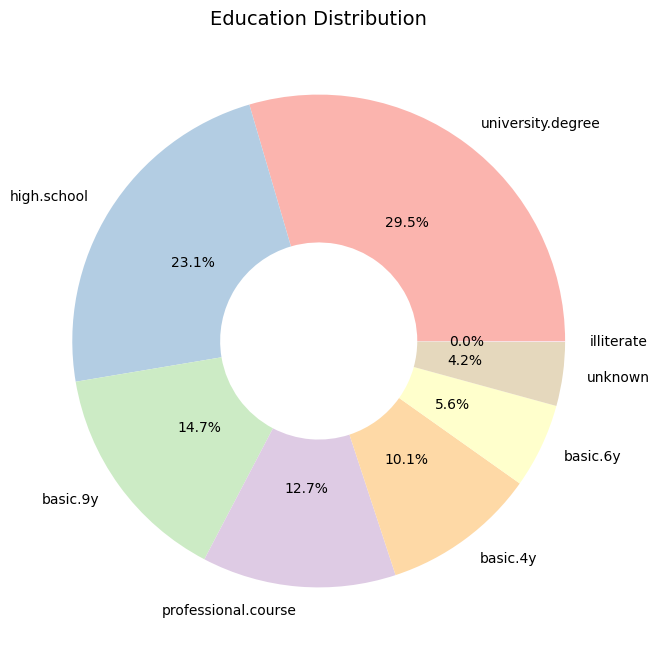

In [43]:
plt.figure(figsize=(8,8))
edu = df['education'].value_counts()
plt.pie(edu, labels=edu.index, autopct='%.1f%%', 
        wedgeprops={'width':0.6}, colors=sns.color_palette('Pastel1'))
plt.title('Education Distribution', fontsize=14)
plt.gca().add_artist(plt.Circle((0,0),0.3,fc='white'))

# Housing Loan Status by Marital Status

Text(0.5, 14.722222222222216, 'Housing Loan')

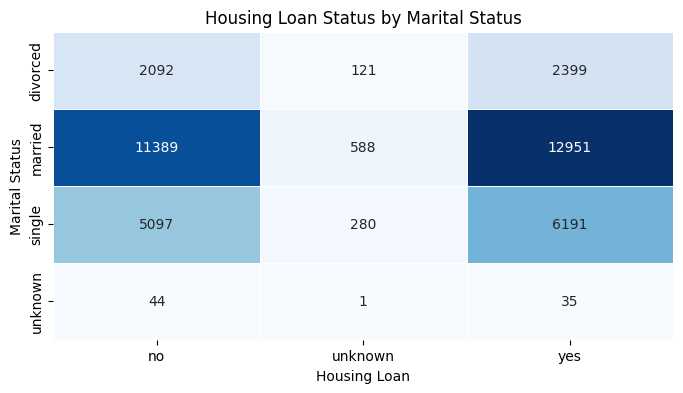

In [44]:
cross_tab = pd.crosstab(df['marital'], df['housing'])
plt.figure(figsize=(8,4))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='Blues', 
           linewidths=0.5, cbar=False)
plt.title('Housing Loan Status by Marital Status')
plt.ylabel('Marital Status')
plt.xlabel('Housing Loan')

# Distribution of age

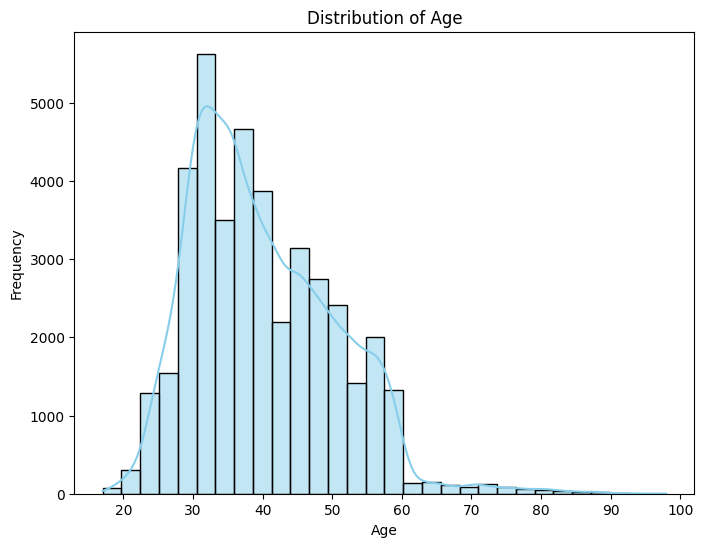

In [45]:
plt.figure(figsize=(8, 6))
sns.histplot(df['age'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Data Cleaning

Every customer is a special case, so it might not be that reasonable to fill NA values by median/predicted values. 

Also, the proportion of NA value is not high in our dataset. Therefore, we decide to drop them.

In [46]:
df.shape

(41188, 9)

In [47]:
#Drop the rows with missing values
df.replace("unknown", float("nan"), inplace=True)
df.dropna(inplace=True)
print(df.shape)


(38245, 9)


The following cells are on coding the dummy variables, binary values, and transfer education level to numerical values. 

In [48]:
# Create dummy variables for 'marital' column
dummies = pd.get_dummies(df['marital'], drop_first=False)
df = pd.concat([df, dummies], axis=1)

In [49]:
# Create dummy variables for 'job' column
dummies = pd.get_dummies(df['job'], drop_first=False)
df = pd.concat([df, dummies], axis=1)

In [50]:
# We encode "education" with ordered number.
# The numerical value represents how many years the clients receive education
edu_unique = df['education'].unique()
print(edu_unique)
encode = {
    'illiterate': 0,
    'basic.4y': 4,
    'basic.6y': 6,
    'basic.9y': 9,
    'high.school': 12,
    'professional.course': 14,
    'university.degree': 16
}

df['education'] = df['education'].map(encode)

['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'university.degree' 'illiterate']


In [51]:
# We turn the binary data type ("yes"/"no") into 1s and 0s.
yes_no = df.select_dtypes(include=['object']).nunique()[df.select_dtypes(include=['object']).nunique() == 2].index
df[yes_no] = df[yes_no].applymap(lambda x: 1 if x == 'yes' else 0)

/tmp/ipykernel_87/2871078849.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[yes_no] = df[yes_no].applymap(lambda x: 1 if x == 'yes' else 0)


In [52]:
# We turn the binary Boolean data type (True/False) into 1s and 0s.
df.replace({True: 1, False: 0}, inplace=True)

/tmp/ipykernel_87/3579049677.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({True: 1, False: 0}, inplace=True)


In [53]:
df.drop(['job', 'marital'], axis=1, inplace=True)

In [54]:
df.head()

,age,education,housing,loan,campaign,previous,y,divorced,married,single,...,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed
0,56,4,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1,57,12,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,37,12,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,40,6,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,56,12,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


# Model Selection and Evaluation

In [55]:
X = df.drop('y', axis=1)
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print("Class distribution before SMOTE (y_train):")
print(y_train.value_counts())
# Apply smote to handle class imbalance
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print("Class distribution after SMOTE (y_train):")
print(y_train.value_counts())

Class distribution before SMOTE (y_train):
y
0    27195
1     3401
Name: count, dtype: int64
Class distribution after SMOTE (y_train):
y
0    27195
1    27195
Name: count, dtype: int64


## First model: Single Layer Perceptron (SLP)

In [56]:
model_slp = Sequential([Dense(1, activation='sigmoid', input_shape=(X_train.shape[1],))])
model_slp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_slp = model_slp.fit(X_train, y_train,epochs=100,batch_size=32,validation_split=0.2,verbose=0)
y_pred_slp = (model_slp.predict(X_test) > 0.5).astype(int)
slp_accuracy = accuracy_score(y_test, y_pred_slp)
print(f"\nSingle Layer Perceptron Accuracy: {slp_accuracy:.4f}")

/opt/conda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-02-26 07:26:14.759245: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

Single Layer Perceptron Accuracy: 0.8366


## Second Model: L2-regularized MLP

In [57]:
model_mlp = Sequential([Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01),input_shape=(X_train.shape[1],)),
                        Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
                        Dense(1, activation='sigmoid')])
model_mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_mlp = model_mlp.fit(X_train, y_train,epochs=100,batch_size=32,validation_split=0.2,verbose=0)
y_pred_mlp = (model_mlp.predict(X_test) > 0.5).astype(int)
mlp_accuracy = accuracy_score(y_test, y_pred_mlp)
print(f"\nL2-Regularized MLP Accuracy: {mlp_accuracy:.4f}")

/opt/conda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

L2-Regularized MLP Accuracy: 0.8510


## Third model: MLP with Tanh Activation Function

In [58]:
model_mlp_tanh = Sequential([Dense(128, activation='tanh', input_shape=(X_train.shape[1],)),  
                             Dense(64, activation='tanh'),                                
                             Dense(1, activation='sigmoid')])
model_mlp_tanh.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_mlp_tanh = model_mlp_tanh.fit(X_train, y_train,epochs=100,batch_size=32,validation_split=0.2,verbose=0  )
y_pred_mlp_tanh = (model_mlp_tanh.predict(X_test) > 0.5).astype(int)
tanh_accuracy = accuracy_score(y_test, y_pred_mlp_tanh)
print(f"\nMLP with Tanh Activation Accuracy: {tanh_accuracy:.4f}")

/opt/conda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

MLP with Tanh Activation Accuracy: 0.7541


L2-regularized MLP performs the best, but we can fine tune the model to try to make it better.

In [59]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
model_final = Sequential([
    Dense(256, activation='relu', kernel_regularizer=l2(0.005), input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=l2(0.005)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.005)),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])
optimizer = RMSprop(learning_rate=0.001)
model_final.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=10, min_lr=1e-8)
early_stop = EarlyStopping(monitor='val_loss', patience=25)
history_final = model_final.fit(X_train_res, y_train_res,epochs=500, batch_size=16, validation_split=0.2,callbacks=[reduce_lr, early_stop],verbose=1)
def evaluate_model(model, X_test, y_test):
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nTuned Model Accuracy: {accuracy:.4f}")
evaluate_model(model_final, X_test_scaled, y_test)

Epoch 1/500


/opt/conda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2720/2720 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.6417 - loss: 1.4001 - val_accuracy: 0.3207 - val_loss: 0.9364 - learning_rate: 0.0010
Epoch 2/500
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.6752 - loss: 0.6500 - val_accuracy: 0.1998 - val_loss: 0.9583 - learning_rate: 0.0010
Epoch 3/500
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.6750 - loss: 0.6359 - val_accuracy: 0.3352 - val_loss: 0.9098 - learning_rate: 0.0010
Epoch 4/500
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.6809 - loss: 0.6307 - val_accuracy: 0.3568 - val_loss: 0.9026 - learning_rate: 0.0010
Epoch 5/500
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.6777 - loss: 0.6316 - val_accuracy: 0.2607 - val_loss: 0.8950 - learning_rate: 0.0010
Epoch 6/500
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.6812 - loss: 0.6274 - val_accuracy: 0.4143 - val_loss: 0.8468 - learning_rate: 0.0010
Epoch 7/500
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.6791 -

The new model improves the accuracy just a little bit. Next, we take a look at the recall rate.

240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


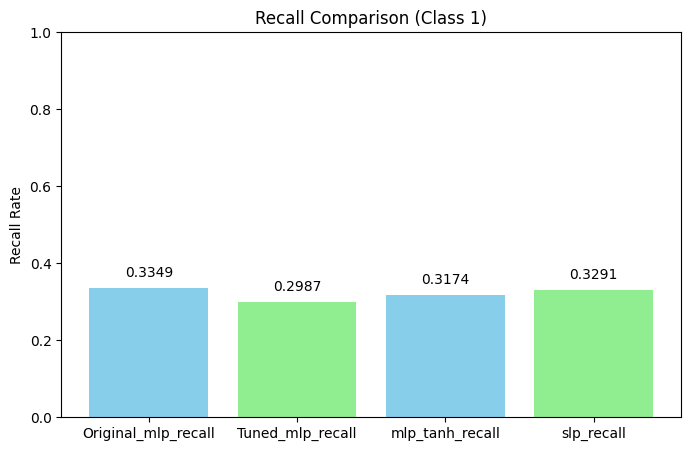

In [60]:
y_pred_mlp = (model_mlp.predict(X_test) > 0.5).astype(int) 
y_pred_final = (model_final.predict(X_test_scaled) > 0.5).astype(int)  
mlp_recall = recall_score(y_test, y_pred_mlp, pos_label=1)
tuned_recall = recall_score(y_test, y_pred_final, pos_label=1)
mlp_tanh_recall = recall_score(y_test, y_pred_mlp_tanh, pos_label=1)
slp_recall = recall_score(y_test, y_pred_slp, pos_label=1)
plt.figure(figsize=(8, 5))
plt.bar(['Original_mlp_recall', 'Tuned_mlp_recall',"mlp_tanh_recall","slp_recall"], 
        [mlp_recall, tuned_recall, mlp_tanh_recall, slp_recall], 
        color=['skyblue', 'lightgreen'])
plt.ylim(0, 1.0)
plt.ylabel('Recall Rate')
plt.title('Recall Comparison (Class 1)')
for i, v in enumerate([mlp_recall, tuned_recall,mlp_tanh_recall,slp_recall]):
    plt.text(i, v+0.03, f"{v:.4f}", ha='center')
plt.show()